In [4]:
#FIND MAX WINDOW FOR CROP

#disregard flow:
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
import numpy as np

c = Config()
c.config['flow']['load'] = False
c.config['pose']['load'] = True
c.config['indexing']['grouping'] = 'person_sequence_angle'

dataset = CasiaDataset()
#for i in range(len(dataset)):
x_max = []
y_max = []
x_center = []
y_center = []
invalid_pose_counter = 0
print("Using",dataset[0]['poses'].shape[0],"poses")
for i in range(5,len(dataset)): 
#for i in range(5):
    #for listitem in dataset: print(listitem)
    item = dataset[i] #generates output
    annotations = item['annotations']
    scenes = item['scenes']
    poses = item['poses']
    #print("Currently in", dataset.dataset_items[i])
    #print("Shapes:")
    #print(poses.shape)
    x_tmp = []
    y_tmp = []
    for j in range(poses.shape[2]):
        if (all(x == 0 for x in poses[:,0,j]) or all(y == 0 for y in poses[:,1,j])):
            print("invalid poses")
        else:
            abs_delta_x = np.max((poses[np.nonzero(poses[:,0,j]),0,j]) 
                                 - np.min(poses[np.nonzero(poses[:,0,j]),0,j]))
            abs_delta_y = np.max((poses[np.nonzero(poses[:,1,j]),1,j]) 
                                  - np.min(poses[np.nonzero(poses[:,1,j]),1,j]))

            x_tmp.append(abs_delta_x)
            y_tmp.append(abs_delta_y)

    x_max.append(max(x_tmp))
    y_max.append(max(y_tmp))

crop_max = [np.ceil(max(x_max)), np.ceil(max(y_max))]
print("Mean:",np.mean(x_max),np.mean(y_max))
print("Crop size as double:",max(x_max),max(y_max))
print("Crop size without margin:",crop_max)


            




/home/ron/anaconda3/envs/gait_37/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Using 12 poses
invalid poses
invalid poses
invalid poses
Mean: 122.44619759999999 162.0498290909091
Crop size as double: 165.692 229.74200000000002
Crop size without margin: [166.0, 230.0]


Using 12 poses
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-01/018/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-01/054/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-01/090/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-01/126/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-01/162/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-02/018/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-02/054/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-02/090/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-02/126/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/001/bg-02/162/
folderpath:  /home/ron/Dokumente/Datasets/Gait/CASIA/pr

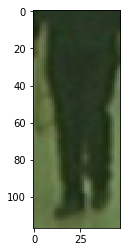

In [15]:
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
c = Config()
c.config['flow']['load'] = False
c.config['pose']['load'] = True
c.config['indexing']['grouping'] = 'person_sequence_angle'

dataset = CasiaDataset()
x_max = []
y_max = []
x_center = []
y_center = []

margin = 10
print("Using", poses.shape[0],"poses")
invalid_pose_counter = 0
im_size_total = [int(crop_max[1] + 2*margin), int(crop_max[0] + 2*margin)]

for i in range(len(dataset)):  
#for i in range(10):
    parentfolder = '{:03d}'.format(dataset.dataset_items[i][0]) 
    anglepath = '{:03d}'.format(dataset.dataset_items[i][2])
    folderpath = '/home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/' + parentfolder + '/'+ dataset.dataset_items[i][1] + '/' + anglepath + '/'
    print("folderpath: ", folderpath)
    pathlib.Path(folderpath).mkdir(parents=True, exist_ok = True)
    
    item = dataset[i] #generates output
    annotations = item['annotations']
    scenes = item['scenes']
    poses = item['poses']
    #print("Shapes:")
    #print(poses.shape)
    x_tmp = []
    y_tmp = []
    for j in range(poses.shape[2]):
    #for j in range(1):    
        if (all(x == 0 for x in poses[:,0,j]) or all(y == 0 for y in poses[:,1,j])):
            print("invalid poses")
            invalid_pose_counter += 1
        else:
            x0 = int(np.floor(np.min(poses[np.nonzero(poses[:,1,j]),1,j]))) - margin
            x1 = int(np.floor(np.max(poses[np.nonzero(poses[:,1,j]),1,j]))) + margin
            y0 = int(np.floor(np.min(poses[np.nonzero(poses[:,0,j]),0,j]))) - margin
            y1 = int(np.floor(np.max(poses[np.nonzero(poses[:,0,j]),0,j]))) + margin
        
            #make sure image borders stay in range
            im_size_tmp = Image.fromarray(scenes[j]).size
            x0 = max(0,x0)
            x1 = min(x1,im_size_tmp[0]-1)
            y0 = max(0,y0)
            y1 = min(y1,im_size_tmp[1]-1)
        
            im_tmp = scenes[j][x0:x1,y0:y1]

            plt.imshow(im)
            x_dif = im_size_total[0] - x1 + x0
            y_dif = im_size_total[1] - y1 + y0
            x_l = np.floor(x_dif/2)
            x_r = np.ceil(x_dif/2)
            y_l = np.floor(y_dif/2)
            y_r = np.ceil(y_dif/2)
        
            im_pad = np.pad(im_tmp,[(int(x_l),int(x_r)),(int(y_l),int(y_r)),(0,0)],'constant')#,'constant', constant_values=((0, 0),(0,0)))

            #plt.imshow(im_pad)

            framename = '{:03d}'.format(j)
            #print("TEST",parentfolder,anglepath,framename)
            filename = parentfolder + '_' + dataset.dataset_items[i][1] + '_' + anglepath + '_' + framename + '.jpg'
            totalpath = folderpath + filename
            #print("Image name", filename)
            #print("Total path", totalpath)
            Image.fromarray(im_pad).save(totalpath)
            #im_save.save(totalpath)
            
            #print("i",i,"j",j,"poses",poses[:,0,j],poses[:,1,j])
            #print("invalid path:",totalpath)
            #plt.imshow(im)
print("Invalid counter:",invalid_pose_counter)

            




In [1]:
# APPLY CROP
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from PIL import Image
dataset = CasiaDataset()
c.config['indexing']['grouping'] = 'person_sequence_angle'
margin = 10
print(crop_max,margin)
for i in range(1):
#for i in range(len(dataset)):
    item = dataset[i]
    annotations = item['annotations']
    scenes = item['scenes']
    poses = item['poses']
    parentfolder = '{:03d}'.format(dataset.dataset_items[i][0]) 
    anglepath = '{:03d}'.format(dataset.dataset_items[i][2])
    folderpath = '/home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/' + parentfolder + '/'+ dataset.dataset_items[i][1] + '/' + anglepath + '/'
    print("folderpath: ", folderpath)
    pathlib.Path(folderpath).mkdir(parents=True, exist_ok = True)
    for j in range(poses.shape[2]):
    #for j in range(10):
        if (min(poses[:,0,j]) == 0 and min(poses[:,1,j]) == 0):
            print("Cropping carefully TODO")
        else:
            #CAREFUL: x and y are changed here in order to match cropping im[x,y]
            #abs_delta_y = np.ceil(max(poses[:,0,j]) - min(poses[:,0,j]))
            #abs_delta_x = np.ceil(max(poses[:,1,j]) - min(poses[:,1,j]))
            center_y = (max(poses[:,0,j]) + min(poses[:,0,j])) / 2;
            center_x = (max(poses[:,1,j]) + min(poses[:,1,j])) / 2;
        im = scenes[j]
        #print(scenes[j].shape)
        x_0 = int(center_x - np.ceil(crop_max[1]/2)) - margin
        x_1 = int(center_x + np.ceil(crop_max[1]/2)) + margin
        y_0 = int(center_y-np.ceil(crop_max[0]/2)) - margin
        y_1 = int(center_y+np.ceil(crop_max[0]/2)) + margin
        
        #print(x_0,x_1,y_0,y_1)
        #print("image dimensions:", abs_delta_x, abs_delta_y)
        if ((x_0 < 0) and (y_0 < 0) and (x_1 > scenes[j].shape[0]) and (y_1 > scenes[j].shape[1])):
            print("problem detected: ",x_0,x_1,y_0,y_1)
        else:
            im_new = im[x_0:x_1,y_0:y_1]
            #x_dif = crop_max+2*margin - abs_delta_x
            #y_dif = crop_max+2*margin - abs_delta_y
            #print("image size: ",crop_max+2*margin)
            #print("image within: ", abs_delta_x, abs_delta_y)
            #print("diff to max crop", x_dif,y_dif)
            #print("center:", center_x, center_y)
            #print("part of interest dim:",abs_delta_x,abs_delta_y)
            #im_pad = np.pad(im_new,[(int(x_dif/2),int(x_dif/2)),(int(y_dif/2),int(y_dif/2)),(0,0)],'constant')#,'constant', constant_values=((0, 0),(0,0)))
            #plt.imshow(scenes[j])
            #plt.plot(poses[:,0,j],poses[:,1,j],'oy')
            #plt.show()
            #plt.imshow(im_pad)
            #plt.show()
            #plt.imshow(im_new)
            #plt.show()
            
            framename = '{:03d}'.format(j)
            #print("TEST",parentfolder,anglepath,framename)
            filename = parentfolder + '_' + dataset.dataset_items[i][1] + '_' + anglepath + '_' + framename + '.jpg'
            totalpath = folderpath + filename
            #print("Image name", filename)
            #print("Total path", totalpath)
            im_save = Image.fromarray(im_new)
            im_save.save(totalpath)
            
print("done")
            

NameError: name 'CasiaDataset' is not defined

In [13]:
type(crop_max)
print(poses.shape[0])

6


In [1]:
# APPLY CROP
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from PIL import Image
dataset = CasiaDataset()
c.config['indexing']['grouping'] = 'person_sequence_angle'
margin = 10
print(crop_max,margin)
for i in range(1):
#for i in range(len(dataset)):
    item = dataset[i]
    annotations = item['annotations']
    scenes = item['scenes']
    poses = item['poses']
    parentfolder = '{:03d}'.format(dataset.dataset_items[i][0]) 
    anglepath = '{:03d}'.format(dataset.dataset_items[i][2])
    folderpath = '/home/ron/Dokumente/Datasets/Gait/CASIA/preprocessing/crops_test/' + parentfolder + '/'+ dataset.dataset_items[i][1] + '/' + anglepath + '/'
    print("folderpath: ", folderpath)
    pathlib.Path(folderpath).mkdir(parents=True, exist_ok = True)
    for j in range(poses.shape[2]):
    #for j in range(10):
        if (min(poses[:,0,j]) == 0 and min(poses[:,1,j]) == 0):
            print("Cropping carefully TODO")
        else:
            #CAREFUL: x and y are changed here in order to match cropping im[x,y]
            #abs_delta_y = np.ceil(max(poses[:,0,j]) - min(poses[:,0,j]))
            #abs_delta_x = np.ceil(max(poses[:,1,j]) - min(poses[:,1,j]))
            center_y = (max(poses[:,0,j]) + min(poses[:,0,j])) / 2;
            center_x = (max(poses[:,1,j]) + min(poses[:,1,j])) / 2;
        im = scenes[j]
        #print(scenes[j].shape)
        x_0 = int(center_x - np.ceil(crop_max[1]/2)) - margin
        x_1 = int(center_x + np.ceil(crop_max[1]/2)) + margin
        y_0 = int(center_y-np.ceil(crop_max[0]/2)) - margin
        y_1 = int(center_y+np.ceil(crop_max[0]/2)) + margin
        
        #print(x_0,x_1,y_0,y_1)
        #print("image dimensions:", abs_delta_x, abs_delta_y)
        if ((x_0 < 0) and (y_0 < 0) and (x_1 > scenes[j].shape[0]) and (y_1 > scenes[j].shape[1])):
            print("problem detected: ",x_0,x_1,y_0,y_1)
        else:
            im_new = im[x_0:x_1,y_0:y_1]
            #x_dif = crop_max+2*margin - abs_delta_x
            #y_dif = crop_max+2*margin - abs_delta_y
            #print("image size: ",crop_max+2*margin)
            #print("image within: ", abs_delta_x, abs_delta_y)
            #print("diff to max crop", x_dif,y_dif)
            #print("center:", center_x, center_y)
            #print("part of interest dim:",abs_delta_x,abs_delta_y)
            #im_pad = np.pad(im_new,[(int(x_dif/2),int(x_dif/2)),(int(y_dif/2),int(y_dif/2)),(0,0)],'constant')#,'constant', constant_values=((0, 0),(0,0)))
            #plt.imshow(scenes[j])
            #plt.plot(poses[:,0,j],poses[:,1,j],'oy')
            #plt.show()
            #plt.imshow(im_pad)
            #plt.show()
            #plt.imshow(im_new)
            #plt.show()
            
            framename = '{:03d}'.format(j)
            #print("TEST",parentfolder,anglepath,framename)
            filename = parentfolder + '_' + dataset.dataset_items[i][1] + '_' + anglepath + '_' + framename + '.jpg'
            totalpath = folderpath + filename
            #print("Image name", filename)
            #print("Total path", totalpath)
            im_save = Image.fromarray(im_new)
            im_save.save(totalpath)
            
print("done")
            

NameError: name 'CasiaDataset' is not defined